In [1]:
# import library
import argparse,copy,h5py, os,sys,time,socket
import numpy as np
import tensorflow as tf
import torch,torchvision,torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from   torchsummary import summary
from   torch.autograd.variable import Variable

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import ticker,colors

# seed value and plotly
init_notebook_mode(connected=True); torch.manual_seed(7); torch.cuda.manual_seed_all(7); np.set_printoptions(suppress=True,precision=3,); tf.set_random_seed(7)

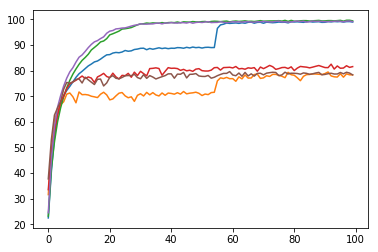

In [9]:
# plot accuracy
a_acurracy_list_train = np.load("./a/a_acurracy_list_train.npy")
a_acurracy_list_test  = np.load("./a/a_acurracy_list_test.npy")

b_acurracy_list_train = np.load("./b/b_acurracy_list_train.npy")
b_acurracy_list_test  = np.load("./b/b_acurracy_list_test.npy")

c_acurracy_list_train = np.load("./c/c_acurracy_list_train.npy")
c_acurracy_list_test  = np.load("./c/c_acurracy_list_test.npy")

plt.plot(a_acurracy_list_train)
plt.plot(a_acurracy_list_test)

plt.plot(b_acurracy_list_train)
plt.plot(b_acurracy_list_test)

plt.plot(c_acurracy_list_train)
plt.plot(c_acurracy_list_test)

In [ ]:
# plot loss
a_acurracy_list_train = np.load("./a/a_loss_list_train.npy.npy")
a_acurracy_list_test  = np.load("./a/a_loss_list_test.npy")

b_acurracy_list_train = np.load("./b/b_acurracy_list_train.npy")
b_acurracy_list_test  = np.load("./b/b_acurracy_list_test.npy")

c_acurracy_list_train = np.load("./c/c_acurracy_list_train.npy")
c_acurracy_list_test  = np.load("./c/c_acurracy_list_test.npy")

plt.plot(a_acurracy_list_train)
plt.plot(a_acurracy_list_test)

plt.plot(b_acurracy_list_train)
plt.plot(b_acurracy_list_test)

plt.plot(c_acurracy_list_train)
plt.plot(c_acurracy_list_test)